### Reproduction of Inception Time algo applied to Fofu dataset from paper by Verket

Run the below cells to get the environment prepared for the TSAI library

In [1]:
!pip install llvmlite==0.38.0 --ignore-installed
!pip install tsai -U >> /dev/null
!pip3 install --upgrade numpy==1.21

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 34.5 MB 17.0 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 15.7 MB 17.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.9.0 requires numpy<=1.19.3, but you have numpy 1.21.0 which is incompatible.


In [3]:
import numpy as np
import torch
from tsai.all import *
from scipy import io

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
computer_setup()

os             : Linux-5.4.0-65-generic-x86_64-with-glibc2.10
python         : 3.8.12
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.10.0a0+0aef44c
n_cpus         : 8
device         : cuda (Quadro M4000)


In [5]:
default_device()

device(type='cuda', index=0)

In [6]:
TIME_WINDOW = 150 # time steps
TOTAL_TIME_STEPS = 12000
N_SUBJECTS = 2
N_CONDITIONS = 9
N_RUNS_TRAIN = 4
N_RUNS_VALID = 1
N_VARIABLES = 4 # number of variables selected for the run (ft, e, u, x)
N_SAMPLES_TRAIN = (TOTAL_TIME_STEPS - TIME_WINDOW) * N_CONDITIONS * N_SUBJECTS * N_RUNS_TRAIN
N_SAMPLES_VALID = (TOTAL_TIME_STEPS - TIME_WINDOW) * N_CONDITIONS * N_SUBJECTS * N_RUNS_VALID

Loads the Fofu data into a dictionary of conditions, where the value of each condtion key is a dictionary of all variables recorded for that condition, where the value of each variable key, is a 3 dimensional matrix of the time stemps, the run number, and the subject number 

In [7]:
data = io.loadmat('expdata.mat', simplify_cells=True)['ed']

In [8]:
data['CL'].keys()

dict_keys(['t', 'ft', 'fd', 'e', 'u', 'x'])

Iterate over all the dictionaries in order to combine it all into one huge 5 dimensional matrix

In [9]:
desired_conds = ['CL', 'CM', 'CH', 'PL', 'PM', 'PH', 'PRL', 'PRM', 'PRH'] # remove non run conditiosn

# as matlab file is loaded as dictionary of conditions with each dictionary having a dictionary
# of variables, with each variable having a dimension 3 array representing time steps per run per subject
# we first iterate over all dictionaries and convert to dimension 5 array for easy slicing :)

# variable indicies on axis=1 are as follow: ['t', 'ft', 'fd', 'e', 'u', 'x']
all_vars_per_cond = []

for cond in desired_conds:
    all_vars_per_cond.append(np.stack(list(data[cond].values())))
    
proc_data = np.stack(all_vars_per_cond)

In [10]:
proc_data.shape # conditions X variables X time step X run_n X subject

(9, 6, 12000, 5, 9)

Now we need to prepare data into 1.5 second segments beginning at each time step in order to prepare the training array

In [11]:
path = Path('./data')
# need to save it to disk as numpy array is too large for ram
X = np.empty((N_SAMPLES_TRAIN + N_SAMPLES_VALID, N_VARIABLES, TIME_WINDOW))
Y = np.empty((N_SAMPLES_TRAIN + N_SAMPLES_VALID,))

var_indices = [1, 3, 4, 5] # select the variables ft, e, u, and x from data
subj_indices = [0, 1] # which subjects to select
run_indices = [0, 1, 2, 3, 4] # which runs to select
valid_run_index = 2
cond_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8] # which conditions to select
cond_labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

sample_index_valid = N_SAMPLES_TRAIN
sample_index_train = 0

splits = (np.arange(0, N_SAMPLES_TRAIN), np.arange(N_SAMPLES_TRAIN, N_SAMPLES_TRAIN + N_SAMPLES_VALID))

for cond_index in cond_indices:
    for subj_index in subj_indices:
        for run_index in run_indices:
            for t in range(TOTAL_TIME_STEPS - TIME_WINDOW):
                if run_index == valid_run_index:
                    X[sample_index_valid] = proc_data[cond_index, var_indices, t:t + TIME_WINDOW, run_index, subj_index]
                    Y[sample_index_valid] = cond_labels[cond_index]
                    sample_index_valid += 1
                else:
                    X[sample_index_train] = proc_data[cond_index, var_indices, t:t + TIME_WINDOW, run_index, subj_index]
                    Y[sample_index_train] = cond_labels[cond_index]
                    sample_index_train += 1


In [12]:
Y[N_SAMPLES_TRAIN - 1],Y[N_SAMPLES_TRAIN], Y[N_SAMPLES_TRAIN + N_SAMPLES_VALID - 1],

(2.0, 0.0, 2.0)

In [13]:
splits

(array([     0,      1,      2, ..., 853197, 853198, 853199]),
 array([ 853200,  853201,  853202, ..., 1066497, 1066498, 1066499]))

### Now onto modelling :)

We use the TSAI library to combine the valid and train data sets into 1

In [14]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)

In [15]:
dsets

(#1066500) [(TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0)), (TSTensor(vars:4, len:150, device=cpu), TensorCategory(0))] ...]

In [16]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()])

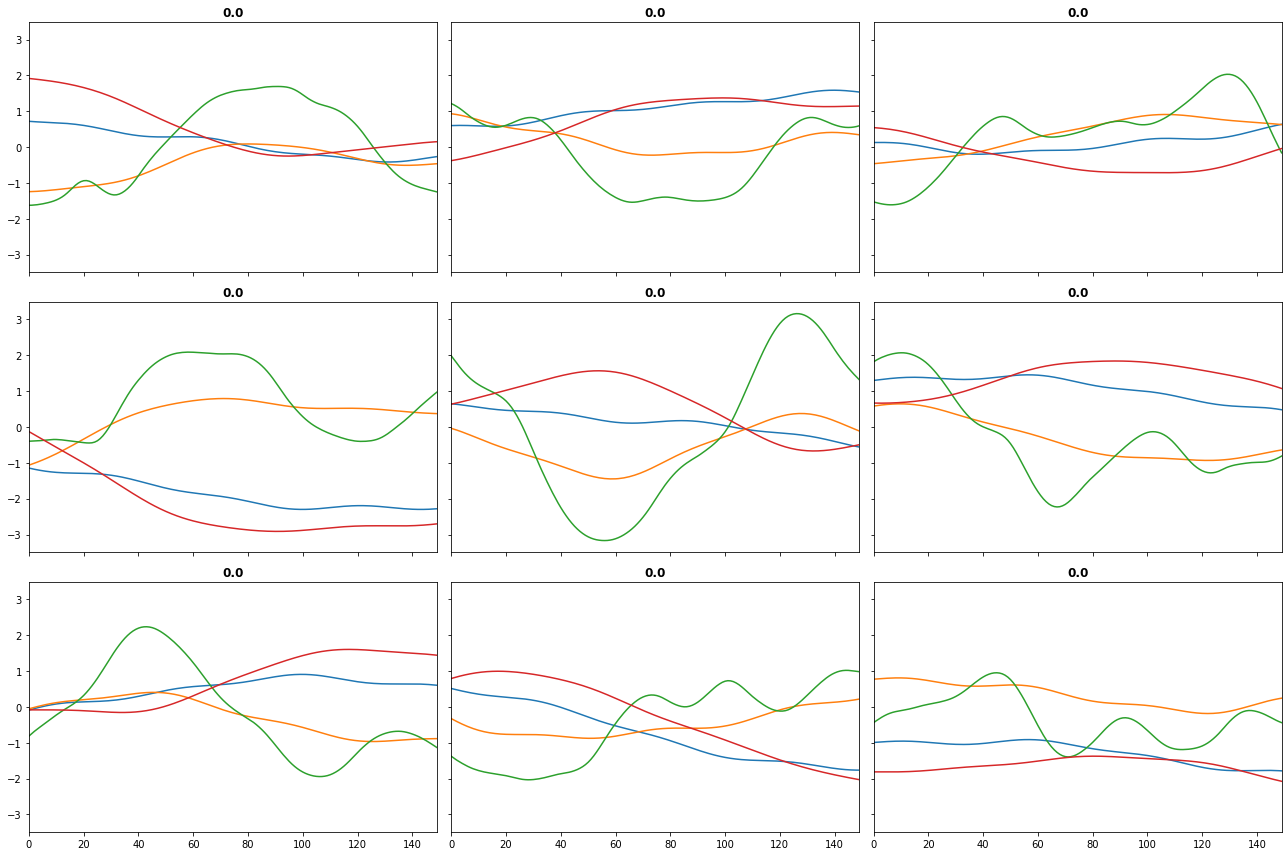

In [17]:
dls.show_batch(sharey=True)

Beautiful ))

In [18]:
model = InceptionTime(dls.vars, dls.c)
learner = Learner(dls, model, metrics=accuracy)
#learner.save('stage0')

In [19]:
#learner = learner.load('stage0')

SuggestedLRs(valley=0.00015848931798245758)

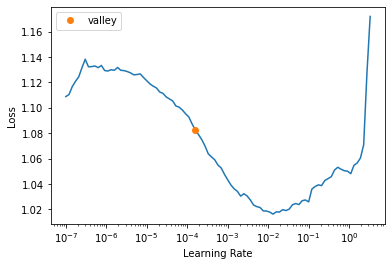

In [20]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.291509,0.636167,0.753024,10:31
1,0.081132,0.884720,0.768050,10:27
